In [1]:
import os
os.chdir("..")
import json
import torch

from matplotlib import pyplot as plt
from torcheval.metrics.functional import binary_auprc

import utils
import metrics
import data_utils

c:\Users\tuoma\miniconda3\envs\pytorch2\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\tuoma\miniconda3\envs\pytorch2\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\tuoma\miniconda3\envs\pytorch2\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints a

## Test parameters

In [ ]:
device = "cuda"
batch_size = 256
activations_dir = 'saved_activations'
clip_name = "ViT-SO400M-14-SigLIP-384"

setting = 7 #which setting to run, following Appendix F.2

In [3]:
if setting == 1:
    dataset_name = "imagenet_val"
    target_name = "vit_b_16_imagenet"
    target_layer = "heads"
    activation_fn = "softmax"
    superclass_concepts = False
    superclass_neurons = False
    concept_source = "gt"

if setting == 2:
    dataset_name = "imagenet_val"
    target_name = "vit_b_16_imagenet"
    target_layer = "heads"
    activation_fn = "softmax"
    superclass_concepts = False
    superclass_neurons = False
    concept_source = "siglip"

if setting == 3:
    dataset_name = "imagenet_val"
    target_name = "vit_b_16_imagenet"
    target_layer = "heads"
    activation_fn = "softmax"
    superclass_concepts = True
    superclass_neurons = True
    concept_source = "gt"

if setting == 4:
    dataset_name = "imagenet_val"
    target_name = "vit_b_16_imagenet"
    target_layer = "heads"
    activation_fn = "softmax"
    superclass_concepts = True
    superclass_neurons = True
    concept_source = "siglip"

elif setting == 5:
    dataset_name = "places365_val"
    target_name = "resnet18_places365"
    target_layer = "fc"
    activation_fn = "softmax"
    superclass_concepts = False
    superclass_neurons = False
    concept_source = "gt"

elif setting == 6:
    dataset_name = "places365_val"
    target_name = "resnet18_places365"
    target_layer = "fc"
    activation_fn = "softmax"
    superclass_concepts = False
    superclass_neurons = False
    concept_source = "siglip"

elif setting == 7:
    dataset_name = "cub_test"
    target_name = "cub_cbm"
    activation_fn = "sigmoid"
    superclass_concepts = False
    superclass_neurons = False
    concept_source = "gt"

elif setting == 8:
    dataset_name = "cub_test"
    target_name = "cub_linear_probe"
    activation_fn = "sigmoid"
    superclass_concepts = False
    superclass_neurons = False
    concept_source = "gt"

elif setting == 9:
    dataset_name = "openwebtext_subset"
    target_name = "gpt2-small"
    activation_fn = None #running softmax inside the model since only including subset of output toks
    superclass_concepts = False
    superclass_neurons = False
    batch_size = 16 #overriding since llm uses more memory
    concept_source = "gt"

elif setting == 10:
    dataset_name = "openwebtext_subset"
    target_name = "gpt2-xl"
    activation_fn = None #running softmax inside the model since only including subset of output toks
    superclass_concepts = False
    superclass_neurons = False
    batch_size = 16 #overriding since llm uses more memory
    concept_source = "gt"

In [4]:
model, preprocess = data_utils.get_target_model(target_name, device=device)
dataset = data_utils.get_data(dataset_name, preprocess)
if dataset_name != "openwebtext_subset":
    pil_data = data_utils.get_data(dataset_name)

In [5]:
if concept_source == "gt":
    if dataset_name == "cub_test":
        concept_activations, text = utils.get_cub_concept_labels(dataset, device, batch_size)
        neuron_activations = utils.get_cub_concept_preds(model, dataset, device, batch_size)
    elif dataset_name == "openwebtext_subset":
        concept_activations, neuron_activations = utils.get_llm_ct_ak(model, dataset, device, batch_size)
    else:
        concept_activations, text = utils.get_onehot_labels(dataset_name, device, superclass_concepts)
        layer_save_path = '{}/{}_{}/{}/'.format(activations_dir, target_name, dataset_name, target_layer)
        neuron_activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, layer_save_path)

elif concept_source == "siglip":
    if dataset_name=="imagenet_val":
        if superclass_concepts:
            concept_set = 'data/imagenet_sc_labels_clean.txt'
        else:
            concept_set = 'data/imagenet_labels_clean.txt'
    elif dataset_name=="places365_val":
        concept_set = 'data/places365_labels_clean.txt'
    with open(concept_set, 'r') as f: 
        text = (f.read()).split('\n')
    concept_activations = utils.get_clip_feats(clip_name = clip_name, dataset_name = dataset_name,
                                                            concept_set = concept_set,  save_dir = activations_dir,
                                                            batch_size = batch_size, device = device)
    layer_save_path = '{}/{}_{}/{}/'.format(activations_dir, target_name, dataset_name, target_layer)
    neuron_activations = utils.save_summary_activations(model, dataset, device, target_layer, batch_size, layer_save_path)


if activation_fn == "softmax":
    neuron_activations = torch.nn.functional.softmax(neuron_activations, dim=1)
elif activation_fn == "sigmoid":
    neuron_activations = torch.nn.functional.sigmoid(neuron_activations)
torch.cuda.empty_cache()

#add constant perturbation
neuron_activations = neuron_activations + 1.0

print(concept_activations.shape, neuron_activations.shape)

torch.Size([5794, 112]) torch.Size([5794, 112])


In [6]:
#check prediction accuracy to make sure loading works, only works for some settings
#print(torch.mean((neuron_activations > 0.5).float() == concept_activations, dtype=float))

Top concepts:
has_bill_shape::dagger tensor(1.)
has_wing_color::brown tensor(1.)
has_upperparts_color::brown tensor(1.)
has_underparts_color::yellow tensor(1.)
has_breast_pattern::multi-colored tensor(1.)


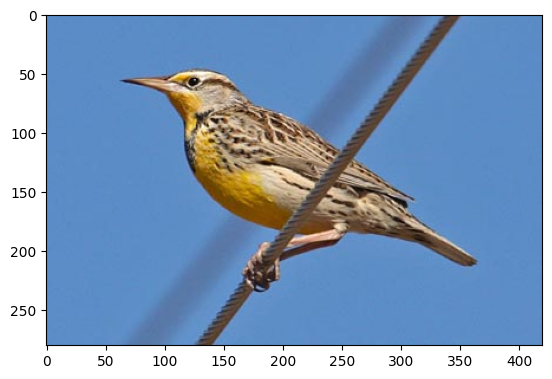

In [7]:
if dataset_name != "openwebtext_subset":
    #check to see inputs and concept labels loaded correctly
    img_id = 2500
    plt.imshow(pil_data[img_id][0])
    vals, ids = torch.sort(concept_activations[img_id], descending=True)
    print("Top concepts:")
    for id in ids[:5]:
        print(text[id], concept_activations[img_id, id].cpu())

In [8]:
#creating superclass neurons, only for imagenet final layer
if superclass_neurons:
    assert(dataset_name=="imagenet_val")
    with open('data/imagenet_superclass_to_ids.json', 'r') as f:
        superclass_to_id = json.load(f)
    
    new_activations = []
    for sclass in superclass_to_id.keys():
        subclasses = superclass_to_id[sclass]
        new_activations.append(torch.sum(torch.stack([neuron_activations[:, i] for i in subclasses], dim=0), dim=0))
    new_activations = torch.stack(new_activations, dim=1)
    print(neuron_activations.shape, new_activations.shape)
    neuron_activations = torch.cat([neuron_activations, new_activations], dim=1)

correct = torch.arange(neuron_activations.shape[1])

In [9]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Split neurons into 5% validation and 95% test set

In [10]:
num_classes = concept_activations.shape[1]
neurons = torch.randperm(neuron_activations.shape[1])
val_neurons = neurons[:int(0.05*len(neurons))].sort()[0]
val_correct = correct[val_neurons]
val_correct = torch.nn.functional.one_hot(val_correct, num_classes=num_classes).to(device)

test_neurons = neurons[int(0.05*len(neurons)):].sort()[0]
test_correct = correct[test_neurons]
test_correct = torch.nn.functional.one_hot(test_correct, num_classes=num_classes).to(device)

## Testing different methods

In [11]:
def find_best_alpha(explanation_fn):
    """
    for fns with only an alpha parameter
    """
    best_auc = -1
    best_alpha = 0

    for alpha in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
        similarities = explanation_fn(neuron_activations[:, val_neurons], concept_activations, alpha=alpha)
        auc = binary_auprc(similarities.flatten(), val_correct.flatten())
        if auc > best_auc:
            best_auc = auc
            best_alpha = alpha
            print("Alpha: {}, Val AUPRC: {:.4f}".format(alpha, auc))

    similarities = explanation_fn(neuron_activations[:, test_neurons], concept_activations, alpha=best_alpha)
    auc = binary_auprc(similarities.flatten(), test_correct.flatten())
    print("Best Alpha: {}, Test AUPRC: {:.4f}".format(best_alpha, auc))

def run_test(explanation_fn):
    """
    for fns with no params
    """
    similarities = explanation_fn(neuron_activations[:, test_neurons], concept_activations)
    auc = binary_auprc(similarities.flatten(), test_correct.flatten())
    print("Test AUPRC: {:.4f}".format(auc))

def find_best_alpha_lam(explanation_fn):
    best_auc = -1
    best_alpha = 0
    best_lam = 0
    for alpha in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
        for lam in [0.01*i for i in range(101)]:
            similarities = explanation_fn(neuron_activations[:, val_neurons], concept_activations, alpha=alpha, lam=lam)
            auc = binary_auprc(similarities.flatten(), val_correct.flatten())
            if auc > best_auc:
                best_auc = auc
                best_alpha = alpha
                best_lam = lam
                print("alpha={}, lam={}, Val AUPRC: {:.4f}".format(alpha, lam, auc))

    similarities = explanation_fn(neuron_activations[:, test_neurons], concept_activations, alpha=best_alpha, lam=best_lam)
    auc = binary_auprc(similarities.flatten(), test_correct.flatten())
    print("Best alpha={}, Best lam={}, Test AUPRC: {:.4f}".format(best_alpha, best_lam, auc))


### Recall

In [12]:
find_best_alpha(metrics.recall)

Alpha: 0.0001, Val AUPRC: 0.0543
Alpha: 0.0002, Val AUPRC: 0.1042
Alpha: 0.0005, Val AUPRC: 0.1136
Alpha: 0.001, Val AUPRC: 0.1282
Alpha: 0.002, Val AUPRC: 0.2123
Alpha: 0.005, Val AUPRC: 0.3700
Alpha: 0.01, Val AUPRC: 0.4369
Alpha: 0.02, Val AUPRC: 0.5350
Best Alpha: 0.02, Test AUPRC: 0.3958


### Precision

In [13]:
find_best_alpha(metrics.precision)

Alpha: 0.0001, Val AUPRC: 0.2378
Alpha: 0.0002, Val AUPRC: 0.2510
Alpha: 0.001, Val AUPRC: 0.2596
Alpha: 0.002, Val AUPRC: 0.2764
Alpha: 0.005, Val AUPRC: 0.3151
Alpha: 0.01, Val AUPRC: 0.3586
Alpha: 0.02, Val AUPRC: 0.3941
Alpha: 0.05, Val AUPRC: 0.4828
Alpha: 0.1, Val AUPRC: 0.6551
Alpha: 0.2, Val AUPRC: 0.6877
Alpha: 0.5, Val AUPRC: 0.8500
Best Alpha: 0.5, Test AUPRC: 0.6803


### F1-score

In [14]:
find_best_alpha(metrics.f1_score)

Alpha: 0.0001, Val AUPRC: 0.2381
Alpha: 0.0002, Val AUPRC: 0.2512
Alpha: 0.001, Val AUPRC: 0.2600
Alpha: 0.002, Val AUPRC: 0.2805
Alpha: 0.005, Val AUPRC: 0.3163
Alpha: 0.01, Val AUPRC: 0.4682
Alpha: 0.02, Val AUPRC: 0.4761
Alpha: 0.05, Val AUPRC: 0.5903
Alpha: 0.1, Val AUPRC: 0.7813
Best Alpha: 0.1, Test AUPRC: 0.6386


### IoU

In [15]:
find_best_alpha(metrics.iou)

Alpha: 0.0001, Val AUPRC: 0.2381
Alpha: 0.0002, Val AUPRC: 0.2512
Alpha: 0.001, Val AUPRC: 0.2600
Alpha: 0.002, Val AUPRC: 0.2805
Alpha: 0.005, Val AUPRC: 0.3163
Alpha: 0.01, Val AUPRC: 0.4682
Alpha: 0.02, Val AUPRC: 0.4761
Alpha: 0.05, Val AUPRC: 0.5903
Alpha: 0.1, Val AUPRC: 0.7813
Best Alpha: 0.1, Test AUPRC: 0.6386


### Accuracy

In [16]:
find_best_alpha(metrics.accuracy)

Alpha: 0.0001, Val AUPRC: 0.0210
Alpha: 0.0002, Val AUPRC: 0.0289
Alpha: 0.0005, Val AUPRC: 0.1067
Alpha: 0.001, Val AUPRC: 0.2068
Alpha: 0.002, Val AUPRC: 0.2068
Alpha: 0.005, Val AUPRC: 0.2070
Alpha: 0.01, Val AUPRC: 0.2071
Alpha: 0.02, Val AUPRC: 0.2076
Alpha: 0.05, Val AUPRC: 0.2133
Alpha: 0.1, Val AUPRC: 0.4376
Alpha: 0.2, Val AUPRC: 0.6433
Best Alpha: 0.2, Test AUPRC: 0.5853


### Balanced Accuracy

In [17]:
find_best_alpha(metrics.balanced_accuracy)

Alpha: 0.0001, Val AUPRC: 0.2600
Alpha: 0.0002, Val AUPRC: 0.3144
Alpha: 0.0005, Val AUPRC: 0.3217
Alpha: 0.001, Val AUPRC: 0.3325
Alpha: 0.002, Val AUPRC: 0.5656
Alpha: 0.005, Val AUPRC: 0.6988
Alpha: 0.01, Val AUPRC: 0.8385
Alpha: 0.05, Val AUPRC: 0.8417
Best Alpha: 0.05, Test AUPRC: 0.7166


### Inverse Balanced Accuracy

In [18]:
find_best_alpha(metrics.inverse_balanced_accuracy)

Alpha: 0.0001, Val AUPRC: 0.2419
Alpha: 0.0002, Val AUPRC: 0.2575
Alpha: 0.0005, Val AUPRC: 0.2581
Alpha: 0.001, Val AUPRC: 0.2731
Alpha: 0.002, Val AUPRC: 0.2995
Alpha: 0.005, Val AUPRC: 0.3272
Alpha: 0.01, Val AUPRC: 0.4858
Alpha: 0.05, Val AUPRC: 0.5567
Alpha: 0.1, Val AUPRC: 0.7782
Alpha: 0.2, Val AUPRC: 0.8233
Best Alpha: 0.2, Test AUPRC: 0.6628


### AUC

In [19]:
find_best_alpha(metrics.auc)

Alpha: 0.0001, Val AUPRC: 0.0519
Alpha: 0.0002, Val AUPRC: 0.2760
Alpha: 0.002, Val AUPRC: 0.3879
Alpha: 0.005, Val AUPRC: 0.5597
Alpha: 0.01, Val AUPRC: 0.7912
Alpha: 0.02, Val AUPRC: 0.7933
Alpha: 0.05, Val AUPRC: 0.8357
Best Alpha: 0.05, Test AUPRC: 0.7045


### Inverse AUC (Classification)

In [20]:
run_test(metrics.inverse_auc)

Test AUPRC: 0.8956


### Correlation

In [21]:
run_test(metrics.correlation)

Test AUPRC: 0.8883


### Correlation top-and-random

In [22]:
run_test(metrics.correlation_top_and_random)

Test AUPRC: 0.7153


### Spearman Correlation

In [23]:
run_test(metrics.spearman_correlation)

Test AUPRC: 0.4233


### Spearman Correlation top-and-random

In [24]:
run_test(metrics.spearman_correlation_top_and_random)

Test AUPRC: 0.4233


### Cosine

In [25]:
run_test(metrics.cos_sim)

Test AUPRC: 0.0443


### WPMI

In [26]:
find_best_alpha_lam(metrics.wpmi)

alpha=0.0001, lam=0.0, Val AUPRC: 0.0543
alpha=0.0001, lam=0.01, Val AUPRC: 0.1600
alpha=0.0002, lam=0.01, Val AUPRC: 0.3144
alpha=0.0005, lam=0.01, Val AUPRC: 0.3283
alpha=0.001, lam=0.01, Val AUPRC: 0.3360
alpha=0.002, lam=0.01, Val AUPRC: 0.4955
alpha=0.002, lam=0.03, Val AUPRC: 0.4955
alpha=0.002, lam=0.52, Val AUPRC: 0.5054
alpha=0.002, lam=0.61, Val AUPRC: 0.5095
alpha=0.002, lam=0.74, Val AUPRC: 0.5139
alpha=0.002, lam=0.76, Val AUPRC: 0.5190
alpha=0.002, lam=0.77, Val AUPRC: 0.5251
alpha=0.002, lam=0.81, Val AUPRC: 0.5324
alpha=0.002, lam=0.8200000000000001, Val AUPRC: 0.5413
alpha=0.002, lam=0.9, Val AUPRC: 0.5524
alpha=0.002, lam=0.91, Val AUPRC: 0.5524
alpha=0.002, lam=0.96, Val AUPRC: 0.5667
alpha=0.002, lam=1.0, Val AUPRC: 0.5867
alpha=0.005, lam=0.01, Val AUPRC: 0.6914
alpha=0.005, lam=0.16, Val AUPRC: 0.6914
alpha=0.005, lam=0.22, Val AUPRC: 0.6969
alpha=0.005, lam=0.38, Val AUPRC: 0.7033
alpha=0.005, lam=0.43, Val AUPRC: 0.7200
alpha=0.005, lam=0.49, Val AUPRC: 0.7311
a

### MAD (Mean Activation Difference)

In [27]:
run_test(metrics.mad)

Test AUPRC: 0.7760


### AUPRC

In [28]:
find_best_alpha(metrics.auprc)

Alpha: 0.0001, Val AUPRC: 0.2448
Alpha: 0.0002, Val AUPRC: 0.2875
Alpha: 0.001, Val AUPRC: 0.3087
Alpha: 0.002, Val AUPRC: 0.3500
Alpha: 0.005, Val AUPRC: 0.5093
Alpha: 0.01, Val AUPRC: 0.6311
Alpha: 0.02, Val AUPRC: 0.6508
Alpha: 0.05, Val AUPRC: 0.7356
Alpha: 0.1, Val AUPRC: 0.8270
Best Alpha: 0.1, Test AUPRC: 0.6712


### Inverse AUPRC

In [29]:
run_test(metrics.inverse_auprc)

Test AUPRC: 0.3977


## Appendix: Combination Metrics

In [30]:
find_best_alpha(metrics.combined_auc)

Alpha: 0.0001, Val AUPRC: 0.5568
Alpha: 0.0002, Val AUPRC: 0.5673
Alpha: 0.0005, Val AUPRC: 0.7274
Alpha: 0.002, Val AUPRC: 0.7513
Alpha: 0.005, Val AUPRC: 0.7958
Alpha: 0.01, Val AUPRC: 0.8714
Alpha: 0.05, Val AUPRC: 0.9000
Best Alpha: 0.05, Test AUPRC: 0.8054


In [31]:
find_best_alpha(metrics.combined_balanced_acc)

Alpha: 0.0001, Val AUPRC: 0.2600
Alpha: 0.0002, Val AUPRC: 0.3144
Alpha: 0.0005, Val AUPRC: 0.3217
Alpha: 0.001, Val AUPRC: 0.3325
Alpha: 0.002, Val AUPRC: 0.5313
Alpha: 0.005, Val AUPRC: 0.6692
Alpha: 0.01, Val AUPRC: 0.7945
Alpha: 0.05, Val AUPRC: 0.8313
Alpha: 0.1, Val AUPRC: 0.8400
Best Alpha: 0.1, Test AUPRC: 0.6896


In [32]:
find_best_alpha(metrics.recall_auc)

Alpha: 0.0001, Val AUPRC: 0.1220
Alpha: 0.0002, Val AUPRC: 0.1342
Alpha: 0.0005, Val AUPRC: 0.1812
Alpha: 0.001, Val AUPRC: 0.2250
Alpha: 0.002, Val AUPRC: 0.5185
Alpha: 0.005, Val AUPRC: 0.6797
Alpha: 0.01, Val AUPRC: 0.8909
Alpha: 0.05, Val AUPRC: 0.9250
Best Alpha: 0.05, Test AUPRC: 0.7989


In [33]:
find_best_alpha(metrics.recall_inv_auc)

Alpha: 0.0001, Val AUPRC: 1.0000
Alpha: 0.0002, Val AUPRC: 1.0000
Best Alpha: 0.0002, Test AUPRC: 0.8725


In [34]:
find_best_alpha(metrics.precision_bal_acc)

Alpha: 0.0001, Val AUPRC: 0.2381
Alpha: 0.0002, Val AUPRC: 0.2510
Alpha: 0.001, Val AUPRC: 0.2599
Alpha: 0.002, Val AUPRC: 0.2764
Alpha: 0.005, Val AUPRC: 0.3157
Alpha: 0.01, Val AUPRC: 0.3952
Alpha: 0.02, Val AUPRC: 0.4628
Alpha: 0.05, Val AUPRC: 0.5037
Alpha: 0.1, Val AUPRC: 0.7026
Alpha: 0.2, Val AUPRC: 0.7064
Alpha: 0.5, Val AUPRC: 0.7192
Best Alpha: 0.5, Test AUPRC: 0.5303


In [35]:
find_best_alpha(metrics.precision_inverse_bal_acc)

Alpha: 0.0001, Val AUPRC: 0.2381
Alpha: 0.0002, Val AUPRC: 0.2510
Alpha: 0.001, Val AUPRC: 0.2596
Alpha: 0.002, Val AUPRC: 0.2764
Alpha: 0.005, Val AUPRC: 0.3151
Alpha: 0.01, Val AUPRC: 0.3586
Alpha: 0.02, Val AUPRC: 0.3941
Alpha: 0.05, Val AUPRC: 0.4842
Alpha: 0.1, Val AUPRC: 0.6602
Alpha: 0.2, Val AUPRC: 0.7302
Alpha: 0.5, Val AUPRC: 0.9250
Best Alpha: 0.5, Test AUPRC: 0.8116
